In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 64
train_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
from torchvision.models import vgg19
model = vgg19()
model.classifier[-1] = nn.Linear(in_features=4096, out_features=10)

model = model.to(device)

In [4]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Train

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=2e-4)

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [7]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 50

In [8]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

100%|██████████| 782/782 [04:30<00:00,  2.89it/s]


Epoch [  1/ 50] 	 Loss: 1.67290     Accuracy: 37.44% 	 Test Loss: 1.23650     Test Accuracy: 56.38%


100%|██████████| 782/782 [04:29<00:00,  2.90it/s]


Epoch [  2/ 50] 	 Loss: 1.03637     Accuracy: 63.08% 	 Test Loss: 0.84788     Test Accuracy: 70.08%


100%|██████████| 782/782 [04:30<00:00,  2.89it/s]


Epoch [  3/ 50] 	 Loss: 0.71514     Accuracy: 74.93% 	 Test Loss: 0.70995     Test Accuracy: 75.97%


100%|██████████| 782/782 [04:29<00:00,  2.90it/s]


Epoch [  4/ 50] 	 Loss: 0.51057     Accuracy: 82.38% 	 Test Loss: 0.69573     Test Accuracy: 76.74%


100%|██████████| 782/782 [04:29<00:00,  2.90it/s]


Epoch [  5/ 50] 	 Loss: 0.31931     Accuracy: 88.95% 	 Test Loss: 0.70197     Test Accuracy: 79.52%


100%|██████████| 782/782 [04:29<00:00,  2.90it/s]


Epoch [  6/ 50] 	 Loss: 0.19924     Accuracy: 93.21% 	 Test Loss: 0.72129     Test Accuracy: 78.92%


100%|██████████| 782/782 [04:29<00:00,  2.90it/s]


Epoch [  7/ 50] 	 Loss: 0.13159     Accuracy: 95.62% 	 Test Loss: 0.93991     Test Accuracy: 78.10%


100%|██████████| 782/782 [04:29<00:00,  2.91it/s]


Epoch [  8/ 50] 	 Loss: 0.09997     Accuracy: 96.65% 	 Test Loss: 0.87270     Test Accuracy: 79.58%


100%|██████████| 782/782 [04:29<00:00,  2.90it/s]


Epoch [  9/ 50] 	 Loss: 0.07831     Accuracy: 97.30% 	 Test Loss: 0.86154     Test Accuracy: 79.76%


100%|██████████| 782/782 [04:29<00:00,  2.91it/s]


Epoch [ 10/ 50] 	 Loss: 0.07669     Accuracy: 97.52% 	 Test Loss: 0.94722     Test Accuracy: 79.02%


100%|██████████| 782/782 [04:28<00:00,  2.91it/s]


Epoch [ 11/ 50] 	 Loss: 0.06366     Accuracy: 97.90% 	 Test Loss: 0.87267     Test Accuracy: 79.15%


100%|██████████| 782/782 [04:28<00:00,  2.91it/s]


Epoch [ 12/ 50] 	 Loss: 0.05315     Accuracy: 98.28% 	 Test Loss: 1.01614     Test Accuracy: 79.47%


100%|██████████| 782/782 [04:28<00:00,  2.91it/s]


Epoch [ 13/ 50] 	 Loss: 0.05611     Accuracy: 98.20% 	 Test Loss: 1.22248     Test Accuracy: 78.06%


100%|██████████| 782/782 [04:28<00:00,  2.91it/s]


Epoch [ 14/ 50] 	 Loss: 0.05523     Accuracy: 98.22% 	 Test Loss: 0.89217     Test Accuracy: 79.09%


100%|██████████| 782/782 [04:28<00:00,  2.92it/s]


Epoch [ 15/ 50] 	 Loss: 0.04812     Accuracy: 98.48% 	 Test Loss: 1.11836     Test Accuracy: 78.31%


100%|██████████| 782/782 [04:28<00:00,  2.92it/s]


Epoch [ 16/ 50] 	 Loss: 0.04615     Accuracy: 98.51% 	 Test Loss: 1.04930     Test Accuracy: 78.98%


100%|██████████| 782/782 [04:28<00:00,  2.92it/s]


Epoch [ 17/ 50] 	 Loss: 0.04104     Accuracy: 98.67% 	 Test Loss: 1.04994     Test Accuracy: 78.99%


100%|██████████| 782/782 [04:28<00:00,  2.91it/s]


Epoch [ 18/ 50] 	 Loss: 0.04287     Accuracy: 98.68% 	 Test Loss: 1.06900     Test Accuracy: 79.43%


100%|██████████| 782/782 [04:28<00:00,  2.92it/s]


Epoch [ 19/ 50] 	 Loss: 0.04240     Accuracy: 98.72% 	 Test Loss: 1.00858     Test Accuracy: 79.36%


100%|██████████| 782/782 [04:28<00:00,  2.91it/s]


Epoch [ 20/ 50] 	 Loss: 0.03431     Accuracy: 98.93% 	 Test Loss: 1.04701     Test Accuracy: 79.90%


100%|██████████| 782/782 [04:28<00:00,  2.92it/s]


Epoch [ 21/ 50] 	 Loss: 0.03566     Accuracy: 98.84% 	 Test Loss: 1.12019     Test Accuracy: 79.35%


100%|██████████| 782/782 [04:28<00:00,  2.92it/s]


Epoch [ 22/ 50] 	 Loss: 0.03479     Accuracy: 98.90% 	 Test Loss: 1.04763     Test Accuracy: 79.90%


100%|██████████| 782/782 [04:28<00:00,  2.92it/s]


Epoch [ 23/ 50] 	 Loss: 0.03167     Accuracy: 98.99% 	 Test Loss: 1.19359     Test Accuracy: 79.45%


100%|██████████| 782/782 [04:28<00:00,  2.92it/s]


Epoch [ 24/ 50] 	 Loss: 0.03279     Accuracy: 98.97% 	 Test Loss: 1.12288     Test Accuracy: 79.33%


100%|██████████| 782/782 [04:27<00:00,  2.92it/s]


Epoch [ 25/ 50] 	 Loss: 0.03304     Accuracy: 99.01% 	 Test Loss: 1.02562     Test Accuracy: 79.86%


100%|██████████| 782/782 [04:27<00:00,  2.92it/s]


Epoch [ 26/ 50] 	 Loss: 0.03104     Accuracy: 99.04% 	 Test Loss: 1.24646     Test Accuracy: 78.84%


100%|██████████| 782/782 [04:27<00:00,  2.92it/s]


Epoch [ 27/ 50] 	 Loss: 0.02693     Accuracy: 99.18% 	 Test Loss: 1.10748     Test Accuracy: 79.45%


100%|██████████| 782/782 [04:27<00:00,  2.92it/s]


Epoch [ 28/ 50] 	 Loss: 0.02970     Accuracy: 99.08% 	 Test Loss: 1.13148     Test Accuracy: 80.18%


100%|██████████| 782/782 [04:27<00:00,  2.92it/s]


Epoch [ 29/ 50] 	 Loss: 0.03066     Accuracy: 99.02% 	 Test Loss: 1.13478     Test Accuracy: 79.82%


100%|██████████| 782/782 [04:27<00:00,  2.92it/s]


Epoch [ 30/ 50] 	 Loss: 0.02613     Accuracy: 99.16% 	 Test Loss: 1.27040     Test Accuracy: 79.88%


100%|██████████| 782/782 [04:27<00:00,  2.92it/s]


Epoch [ 31/ 50] 	 Loss: 0.02720     Accuracy: 99.13% 	 Test Loss: 1.43237     Test Accuracy: 78.36%


 64%|██████▍   | 499/782 [02:51<01:37,  2.92it/s]


KeyboardInterrupt: 

In [9]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 28 with test accuracy: 80.18%


# Plot results

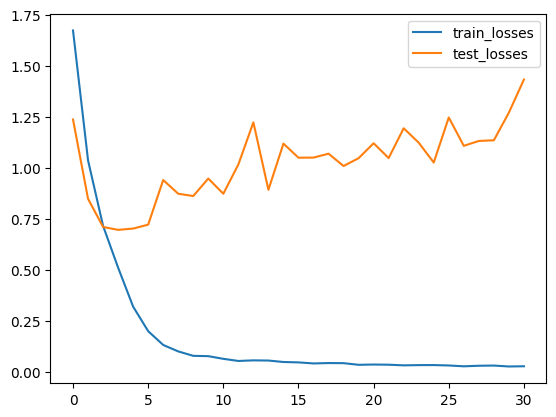

In [10]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

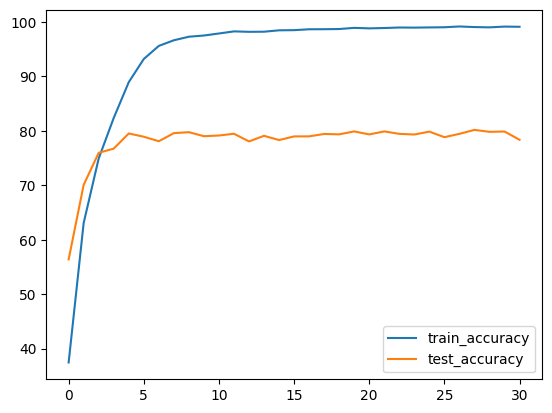

In [11]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()